# CUSTOMER CHURN CHALLENGE ON ZINDI

# Project Description

This challenge is for an African telecommunications company that provides customers with airtime and mobile data bundles. The objective of this challenge is to develop a machine learning model to predict the likelihood of each customer “churning”, i.e. becoming inactive and not making any transactions for 90 days.

This solution will help this telecom company to better serve their customers by understanding which customers are at risk of leaving.

# Hypothesis

Null Hypothesis: There is no relationship between the tenure and the churn of customers.

Alternate Hypothesis: There is a relationship between the tenure and the churn of customers.

# Analytical Questions

1. What is the overall churn rate of the telecommunication company?
2. What is the churn rate across the various regions?
3. What is the churn rate of custmers based on customer regularity?
4. What is the churn rate of customers based on their tenure?
(Group customers to short-term, mid-term and long term based on their tenure, then check the churn rate)
5. What is the churn rate of customers based on the top_up amounts?
(Group top_up amount to high, medium and low, then check the churn rate across the groups)
6. What is the churn rate of top pack users?
7. What is the churn rate based on the data volume?
8. What is the churn rate of custmers based on their income frequency?
9. What is the churn rate of customers based on their monthly income?
(Group monthly income to high-income earners, medium income earners, and low income earners, then check the churn rate across them)
10. What is the relationship between the monthly income of customers and the frequency of their recharge (the number of times a customer activated the top pack packages)?
11. What is the relationship between the number of times a customer made an income and the number of times a customer activated the top pack?
12. What is the churn distribution of customers based on calls to Zone1 and Zone 2?
13. What is the churn distribution of customers based international calls, calls to Orange, and calls to Tigo?

In [190]:
# Installations

!pip install huggingface_hub

In [191]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import os
from google.colab import drive

import scipy.stats as stats

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from huggingface_hub import notebook_login

# Data Exploration

In [192]:
# Load the datasets

# train = pd.read_csv('Train.csv')
# test=  pd.read_csv('Test.csv')
# submission = pd.read_csv('SampleSubmission.csv')

In [193]:
# Mount Google Drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [194]:
# Define the directory path to access the datasets
data_path = '/content/drive/MyDrive/Google Colab/Customer Churn Challenge on Zindi/Assets/'

# Define the directory path to save images
image_path = '/content/drive/MyDrive/Google Colab/Customer Churn Challenge on Zindi/Images'

In [195]:
# Load the datasets from the drive using the data_path

train = pd.read_csv(data_path + 'Train.csv')
test=  pd.read_csv(data_path + 'Test.csv')
submission = pd.read_csv(data_path + 'SampleSubmission.csv')

In [196]:
# Display the first five rows of the train dataset

train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,7ee9e11e342e27c70455960acc80d3f91c1286d1,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,185.0,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,30.0,0
1,50443f42bdc92b10388fc56e520e4421a5fa655c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
2,da90b5c1a9b204c186079f89969aa01cb03c91b2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
3,364ec1b424cdc64c25441a444a16930289a0051e,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,20.0,NaN,2.0,NO,61,"Data:490F=1GB,7d",7.0,0
4,d5a5247005bc6d41d3d99f4ef312ebb5f640f2cb,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,34.0,NaN,NaN,NO,56,All-net 500F=2000F;5d,11.0,0


In [197]:
# Display the last five rows of the train dataset

train.tail()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
1077019,56e22fe3312a48cf860b043a021dab275383a20a,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,16,NaN,NaN,0
1077020,587b72930e4d36b3fb94a18c3ef65c2079460eee,TAMBACOUNDA,K > 24 month,2500.0,5.0,2500.0,833.0,5.0,0.0,15.0,77.0,NaN,NaN,NaN,NO,34,All-net 500F=2000F;5d,2.0,0
1077021,d6831b8edacb7d9928b3f053fb1283574577ae42,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,1
1077022,cb1f6510b084173c0deae49095f35ac29f916701,NaN,K > 24 month,600.0,1.0,600.0,200.0,1.0,591.0,11.0,37.0,5.0,1.0,NaN,NO,16,All-net 600F= 3000F ;5d,1.0,0
1077023,28f56fd0d9f8d8647bb6c62e7a3f4f35f49f4d6f,FATICK,K > 24 month,1500.0,4.0,1499.0,500.0,5.0,1265.0,30.0,4.0,NaN,NaN,0.0,NO,50,On net 200F=Unlimited _call24H,2.0,0


In [198]:
# Obtain the shape of the train data

train.shape

(1077024, 19)

In [199]:
# View columns of the train data and their datatypes

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077024 entries, 0 to 1077023
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1077024 non-null  object 
 1   REGION          652687 non-null   object 
 2   TENURE          1077024 non-null  object 
 3   MONTANT         699139 non-null   float64
 4   FREQUENCE_RECH  699139 non-null   float64
 5   REVENUE         714669 non-null   float64
 6   ARPU_SEGMENT    714669 non-null   float64
 7   FREQUENCE       714669 non-null   float64
 8   DATA_VOLUME     547261 non-null   float64
 9   ON_NET          683850 non-null   float64
 10  ORANGE          629880 non-null   float64
 11  TIGO            432250 non-null   float64
 12  ZONE1           84898 non-null    float64
 13  ZONE2           68794 non-null    float64
 14  MRG             1077024 non-null  object 
 15  REGULARITY      1077024 non-null  int64  
 16  TOP_PACK        626129 non-null   ob

In [200]:
# Display the first five rows of the test dataset

test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,MATAM,I 18-21 month,2500.0,5.0,2500.0,833.0,5.0,0.0,64.0,70.0,NaN,NaN,NaN,NO,35,All-net 500F=2000F;5d,5.0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN
2,5a4db591c953a8d8f373877fad37aaf4268899a1,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NO,22,NaN,NaN
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,SAINT-LOUIS,K > 24 month,5100.0,7.0,5637.0,1879.0,15.0,7783.0,30.0,24.0,0.0,0.0,NaN,NO,60,"Data:1000F=2GB,30d",4.0


In [201]:
# Display the last five rows of the test dataset

test.tail()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
190058,1092956a3dad77ceb7e8d7c70e3e13f77b60e2aa,DAKAR,F 9-12 month,500.0,1.0,506.0,169.0,1.0,0.0,26.0,NaN,NaN,6.0,NaN,NO,14,All-net 500F=2000F;5d,1.0
190059,bec10becca7faa8e9cab9981b3aee5e9a7f04828,DAKAR,K > 24 month,2000.0,4.0,2000.0,667.0,5.0,0.0,8.0,54.0,NaN,NaN,NaN,NO,29,All-net 500F =2000F_AllNet_Unlimited,3.0
190060,7ac6fc191f8732b1b146e57f9ede983626b93eae,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN
190061,d592c81971d6120b0d19f9ace85f278ea21b89a0,NaN,K > 24 month,300.0,2.0,298.0,99.0,2.0,0.0,1.0,2.0,NaN,NaN,NaN,NO,12,NaN,NaN
190062,9b4f57aeef72cd52c634498d0ea27ea3fbb67bf4,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN


In [202]:
# Obtain the shape of the test dataset

test.shape

(190063, 18)

In [203]:
# View the columns and datatypes of the test dataset

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190063 entries, 0 to 190062
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         190063 non-null  object 
 1   REGION          115330 non-null  object 
 2   TENURE          190063 non-null  object 
 3   MONTANT         123695 non-null  float64
 4   FREQUENCE_RECH  123695 non-null  float64
 5   REVENUE         126422 non-null  float64
 6   ARPU_SEGMENT    126422 non-null  float64
 7   FREQUENCE       126422 non-null  float64
 8   DATA_VOLUME     96716 non-null   float64
 9   ON_NET          120771 non-null  float64
 10  ORANGE          111417 non-null  float64
 11  TIGO            76555 non-null   float64
 12  ZONE1           14850 non-null   float64
 13  ZONE2           12011 non-null   float64
 14  MRG             190063 non-null  object 
 15  REGULARITY      190063 non-null  int64  
 16  TOP_PACK        110773 non-null  object 
 17  FREQ_TOP_P

In [204]:
# List all the columns in the train and test dataset

train.columns, test.columns

(Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
        'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
        'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
        'CHURN'],
       dtype='object'),
 Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
        'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
        'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK'],
       dtype='object'))

The train and test datatypes have the same columns with the same datatypes, except that the train dataset has a 'CHURN' column which is absent in the test data. This 'CHURN' column is the target variable.

In [205]:
# Display the first five rows of the submission dataset

submission.head()

,user_id,CHURN
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,0
2,5a4db591c953a8d8f373877fad37aaf4268899a1,0
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,0
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,0


In [206]:
# Obtain the shape of the submission dataset

submission.shape

(190063, 2)

# Examine Missing Values

The missing values in the train and test dataset will be handled using the same procedure to ensure consistency.

In [207]:
# Identify the columns with missing values in train dataset

train.isnull().sum()

user_id                 0
REGION             424337
TENURE                  0
MONTANT            377885
FREQUENCE_RECH     377885
REVENUE            362355
ARPU_SEGMENT       362355
FREQUENCE          362355
DATA_VOLUME        529763
ON_NET             393174
ORANGE             447144
TIGO               644774
ZONE1              992126
ZONE2             1008230
MRG                     0
REGULARITY              0
TOP_PACK           450895
FREQ_TOP_PACK      450895
CHURN                   0
dtype: int64

In [208]:
# Calculate the percentage of missing values for each column
missing_percentage = (train.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_percentage_df = pd.DataFrame({'Column Name': missing_percentage.index, 'Missing Percentage (%)': missing_percentage})

# Display the DataFrame
print(missing_percentage_df)

                   Column Name  Missing Percentage (%)
user_id                user_id                    0.00
REGION                  REGION                   39.40
TENURE                  TENURE                    0.00
MONTANT                MONTANT                   35.09
FREQUENCE_RECH  FREQUENCE_RECH                   35.09
REVENUE                REVENUE                   33.64
ARPU_SEGMENT      ARPU_SEGMENT                   33.64
FREQUENCE            FREQUENCE                   33.64
DATA_VOLUME        DATA_VOLUME                   49.19
ON_NET                  ON_NET                   36.51
ORANGE                  ORANGE                   41.52
TIGO                      TIGO                   59.87
ZONE1                    ZONE1                   92.12
ZONE2                    ZONE2                   93.61
MRG                        MRG                    0.00
REGULARITY          REGULARITY                    0.00
TOP_PACK              TOP_PACK                   41.86
FREQ_TOP_P

Some of the columns have the same number of missing values. This suggests that it is possible that the same rows have missing values across these columns. We will examine the top 20 rows with missing values.

In [209]:
# Create a boolean mask to identify the rows with missing values
missing_mask = train.isnull()

# Use the mask to filter rows with missing values
rows_with_missing_values = train[missing_mask]

# Display the first 20 rows with missing values
rows_with_missing_values.head(20)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As shown above, the top 20 rows with missing values have missing values across all the columns. However, the "isnull()" method used earlier indicated that there are some columns without missing values.

# Visualization of some columns in the *dataset*

DAKAR          256259
THIES           90171
SAINT-LOUIS     59895
LOUGA           49679
KAOLACK         48498
DIOURBEL        33564
TAMBACOUNDA     27562
KAFFRINE        22067
KOLDA           19464
FATICK          17775
MATAM           14650
ZIGUINCHOR      11036
SEDHIOU          1553
KEDOUGOU          514
Name: REGION, dtype: int64


Text(0.5, 0, 'REGION')

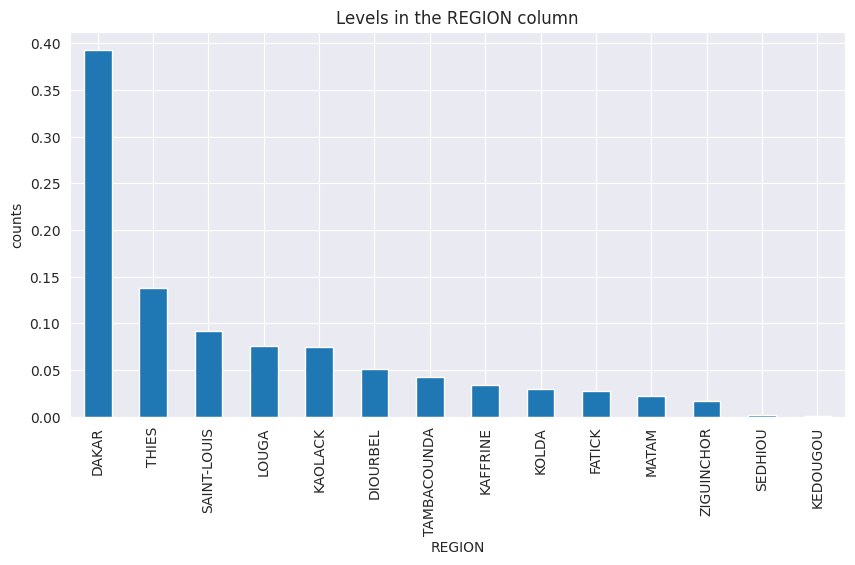

In [210]:
# Check the levels in the 'REGION' column

print(train['REGION'].value_counts())
plt.figure(figsize=(10,5))
train['REGION'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the REGION column')
plt.ylabel('counts')
plt.xlabel('REGION')

From the plot above, most of the customers are located in Dakar, followed by Thies and Saint-Louis. Kedougou is the region with the least number of customers.

K > 24 month     1021853
I 18-21 month      22494
H 15-18 month      12913
G 12-15 month       7520
J 21-24 month       6324
F 9-12 month        4604
E 6-9 month          929
D 3-6 month          387
Name: TENURE, dtype: int64


Text(0.5, 0, 'TENURE')

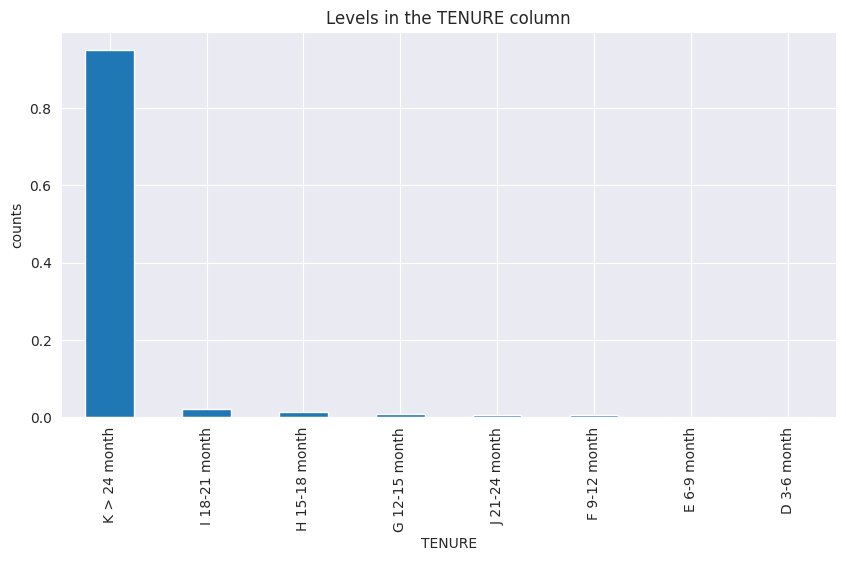

In [211]:
# Check the levels in the 'TENURE' column

print(train['TENURE'].value_counts())
plt.figure(figsize=(10,5))
train['TENURE'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the TENURE column')
plt.ylabel('counts')
plt.xlabel('TENURE')

A huge percentage of the customers captured in the train dataset have stayed with the telecommunication company for over 24 months. This implies that the dataset is focused on old customers.

K > 24 month     180265
I 18-21 month      4017
H 15-18 month      2287
G 12-15 month      1369
J 21-24 month      1096
F 9-12 month        811
E 6-9 month         153
D 3-6 month          65
Name: TENURE, dtype: int64


Text(0.5, 0, 'TENURE')

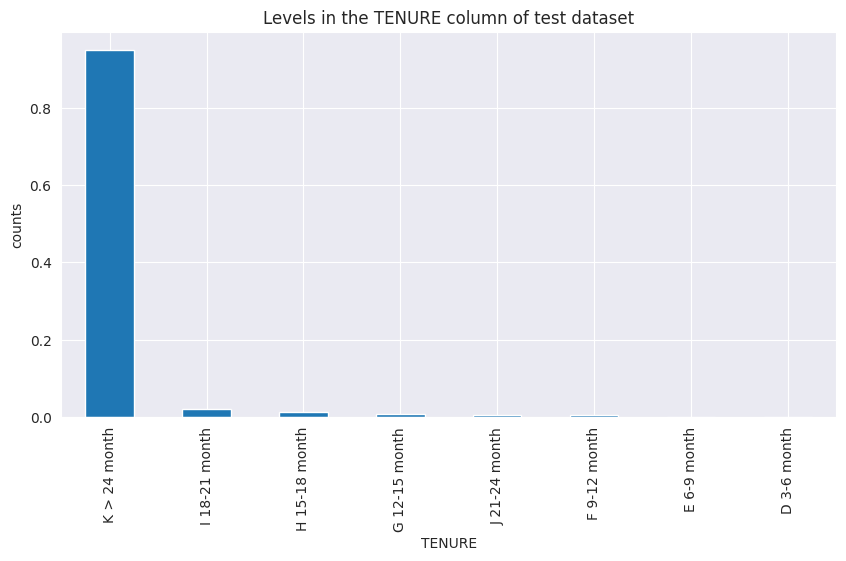

In [212]:
# Check the levels in the TENURE column of test dataset

print(test['TENURE'].value_counts())
plt.figure(figsize=(10,5))
test['TENURE'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the TENURE column of test dataset')
plt.ylabel('counts')
plt.xlabel('TENURE')

Both the train and test datasets focus on old customers, that is, customers that have been with the telecommunication network for over 24 months.

NO    1077024
Name: MRG, dtype: int64


Text(0.5, 0, 'MRG')

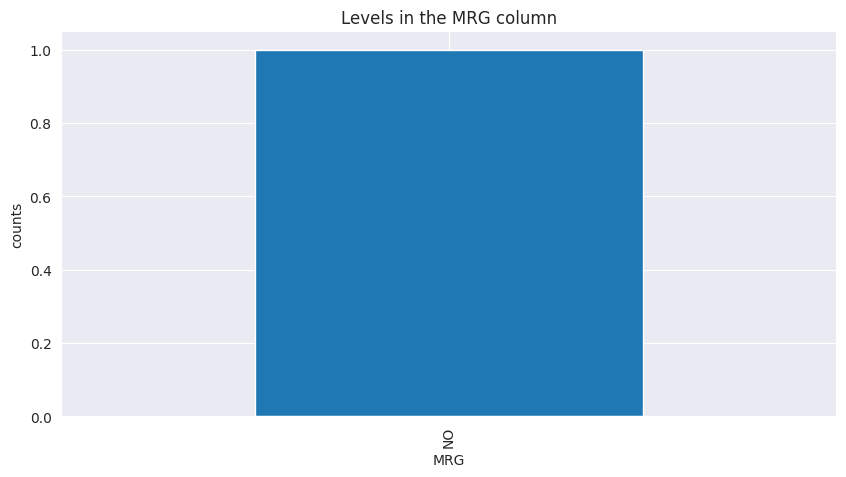

In [213]:
# Check the levels in the MRG column

print(train['MRG'].value_counts())
plt.figure(figsize=(10,5))
train['MRG'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the MRG column')
plt.ylabel('counts')
plt.xlabel('MRG')

The MRG indicates if a client is going. The chart above shows that none of the customers in the train dataset is going.

NO    190063
Name: MRG, dtype: int64


Text(0.5, 0, 'MRG')

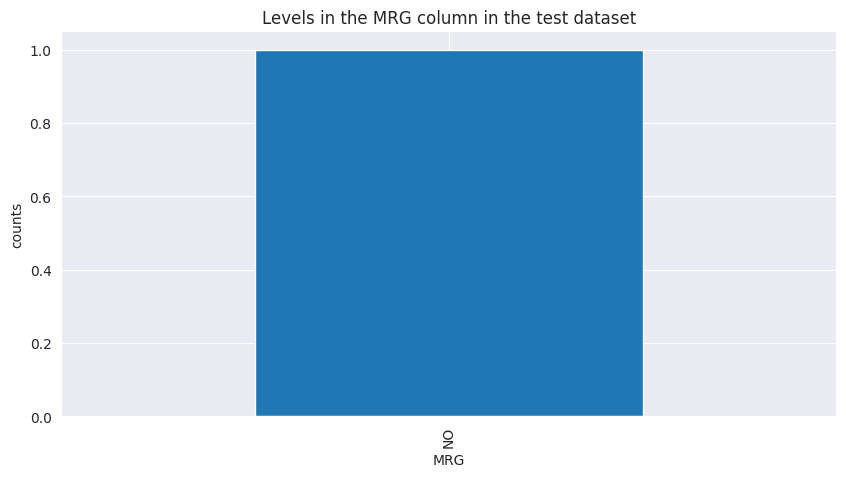

In [214]:
# Check the levels in the MRG column in the test dataset

print(test['MRG'].value_counts())
plt.figure(figsize=(10,5))
test['MRG'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the MRG column in the test dataset')
plt.ylabel('counts')
plt.xlabel('MRG')

The MRG indicates if a client is going. The chart above shows that none of the customers in the test dataset is going.

All-net 500F=2000F;5d                          158779
On net 200F=Unlimited _call24H                  76302
Data:490F=1GB,7d                                57679
Data: 100 F=40MB,24H                            42515
Mixt 250F=Unlimited_call24H                     33620
MIXT:500F= 2500F on net _2500F off net;2d       32164
Data:1000F=2GB,30d                              29982
All-net 500F =2000F_AllNet_Unlimited            23476
Jokko_Daily                                     22548
Data: 200 F=100MB,24H                           21515
IVR Echat_Daily_50F                             14316
On-net 500=4000,10d                             13371
On-net 500F_FNF;3d                              11089
Data:200F=Unlimited,24H                         10986
MIXT: 200mnoff net _unl on net _5Go;30d          9612
On-net 1000F=10MilF;10d                          9302
Data:1000F=5GB,7d                                7470
VAS(IVR_Radio_Daily)                             7376
Twter_U2opia_Daily          

Text(0.5, 0, 'TOP_PACK')

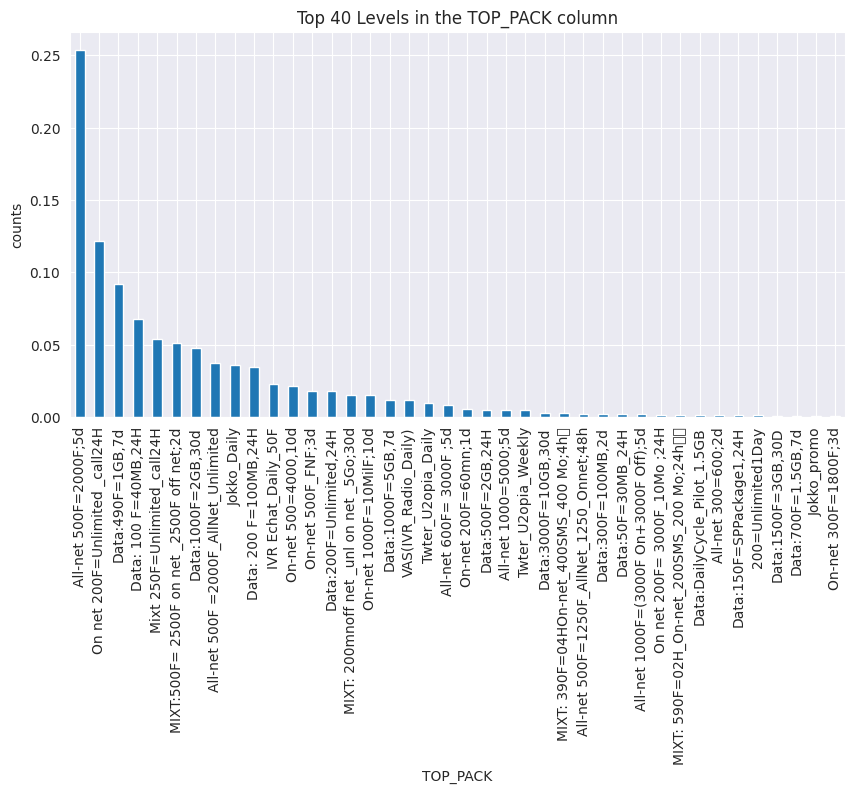

In [215]:
# Check the top 40 levels in the TOP_PACK column

print(train['TOP_PACK'].value_counts().head(40))
plt.figure(figsize=(10,5))
train['TOP_PACK'].value_counts(normalize=True).head(40).plot(kind='bar')
plt.title('Top 40 Levels in the TOP_PACK column')
plt.ylabel('counts')
plt.xlabel('TOP_PACK')

0    875031
1    201993
Name: CHURN, dtype: int64


Text(0.5, 0, 'CHURN')

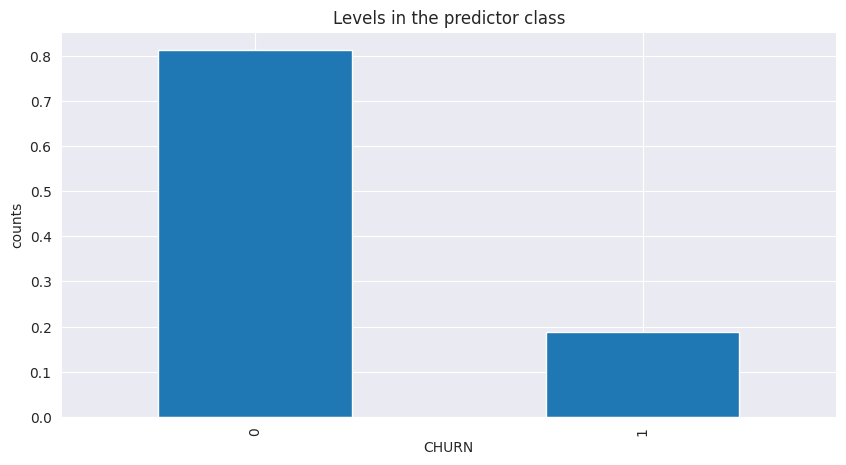

In [216]:
# Check if the predictor class is balanced

print(train['CHURN'].value_counts())
plt.figure(figsize=(10,5))
train['CHURN'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the predictor class')
plt.ylabel('counts')
plt.xlabel('CHURN')

In [217]:
# Check the summary of numerical fields and apply transpose to easily display all the columns

summary_statistics = train.select_dtypes(include=['int64', 'float64']).describe().T
summary_statistics

,count,mean,std,min,25%,50%,75%,max
MONTANT,699139.0,5529.210895,7104.737952,20.0,1000.0,3000.0,7350.0,470000.0
FREQUENCE_RECH,699139.0,11.523756,13.261938,1.0,2.0,7.0,16.0,131.0
REVENUE,714669.0,5506.050798,7175.625010,1.0,1000.0,3000.0,7360.0,532177.0
ARPU_SEGMENT,714669.0,1835.355961,2391.870902,0.0,333.0,1000.0,2453.0,177392.0
FREQUENCE,714669.0,13.974439,14.687059,1.0,3.0,9.0,20.0,91.0
DATA_VOLUME,547261.0,3368.801722,12898.928039,0.0,0.0,258.0,2905.0,1702309.0
ON_NET,683850.0,277.065798,874.315378,0.0,5.0,27.0,156.0,50809.0
ORANGE,629880.0,95.160804,203.020261,0.0,7.0,29.0,99.0,12040.0
TIGO,432250.0,23.105018,64.035464,0.0,2.0,6.0,20.0,4174.0
ZONE1,84898.0,8.167483,39.245883,0.0,0.0,1.0,3.0,2507.0


<Axes: >

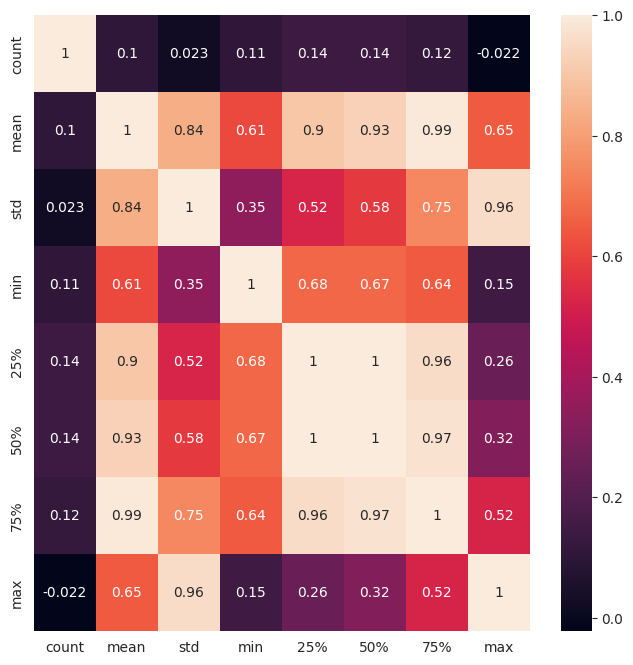

In [218]:
# Plot the correlation matrix using heatmap

sb.heatmap(summary_statistics.corr(), annot=True)

In [219]:
# Check for missing values in train dataset

train.isnull().sum()

user_id                 0
REGION             424337
TENURE                  0
MONTANT            377885
FREQUENCE_RECH     377885
REVENUE            362355
ARPU_SEGMENT       362355
FREQUENCE          362355
DATA_VOLUME        529763
ON_NET             393174
ORANGE             447144
TIGO               644774
ZONE1              992126
ZONE2             1008230
MRG                     0
REGULARITY              0
TOP_PACK           450895
FREQ_TOP_PACK      450895
CHURN                   0
dtype: int64

In [220]:
# Check for missing values in test dataset

test.isnull().sum()

user_id                0
REGION             74733
TENURE                 0
MONTANT            66368
FREQUENCE_RECH     66368
REVENUE            63641
ARPU_SEGMENT       63641
FREQUENCE          63641
DATA_VOLUME        93347
ON_NET             69292
ORANGE             78646
TIGO              113508
ZONE1             175213
ZONE2             178052
MRG                    0
REGULARITY             0
TOP_PACK           79290
FREQ_TOP_PACK      79290
dtype: int64

# Hypothesis Testing

Null Hypothesis: There is no relationship between the tenure and the churn of customers.

Alternate Hypothesis: There is a relationship between the tenure and the churn of customers.

In [221]:
# Define the null hypothesis and alternative hypothesis
null_hypothesis = 'There is no relationship between the tenure and churn of customers.'
alternative_hypothesis = 'There is a relationship between the tenure and churn of customers.'

# Perform the chi-square test
observed = pd.crosstab(train['TENURE'], train['CHURN'])
chi2, p_value, _, _ = stats.chi2_contingency(observed)

# Set the significance level
alpha = 0.05

# Print the test results
print('Null Hypothesis:', null_hypothesis)
print('Alternative Hypothesis:', alternative_hypothesis)
print('Significance Level (alpha):', alpha)
print('Chi-square statistic:', chi2)
print('P-value:', p_value)

# Compare the p-value with the significance level
if p_value < alpha:

    print(f'Result: Reject the null hypothesis.', alternative_hypothesis)
else:
    print(f'Result: Fail to reject the null hypothesis.', null_hypothesis)

Null Hypothesis: There is no relationship between the tenure and churn of customers.
Alternative Hypothesis: There is a relationship between the tenure and churn of customers.
Significance Level (alpha): 0.05
Chi-square statistic: 2898.5207691813353
P-value: 0.0
Result: Reject the null hypothesis. There is a relationship between the tenure and churn of customers.


 The P-value of 0.0 suggests a strong evidence against the null hypothesis, indicating a statistically significant result. There is a strong relationship between customer tenure and customer churn.

# Answering Analytical Questions

## Questions

1. What is the overall churn rate of the telecommunication company?
2. What is the churn rate across the various regions?
3. What is the churn rate of custmers based on customer regularity?
4. What is the churn rate of customers based on their tenure?
(Group customers to short-term, mid-term and long term based on their tenure, then check the churn rate)
5. What is the churn rate of customers based on the top_up amounts?
(Group top_up amount to high, medium and low, then check the churn rate across the groups)
6. What is the churn rate of top pack users?
7. What is the churn rate based on the data volume?
8. What is the churn rate of custmers based on their income frequency?
9. What is the churn rate of customers based on their monthly income?
(Group monthly income to high-income earners, medium income earners, and low income earners, then check the churn rate across them)
10. What is the relationship between the monthly income of customers and the frequency of their recharge (the number of times a customer activated the top pack packages)?
11. What is the relationship between the number of times a customer made an income and the number of times a customer activated the top pack?
12. What is the churn distribution of customers based on calls to Zone1 and Zone 2?
13. What is the churn distribution of customers based international calls, calls to Orange, and calls to Tigo?

Question 1: What is the overall churn rate of the telecommunication company?

Total Customers: 1077024
Churned Customers: 201993
Churn Rate: 18.8%


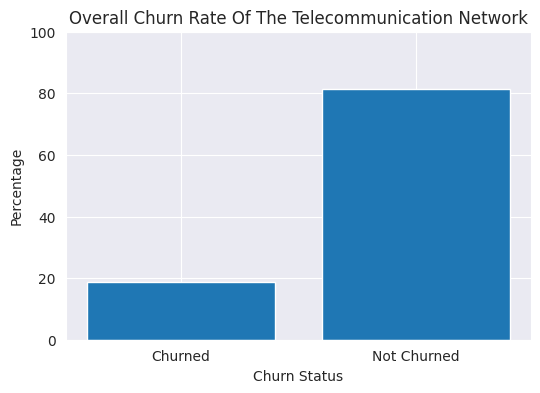

In [222]:
# Calculate the churn rate
total_customers = len(train)
churned_customers = train['CHURN'].sum()
churn_rate = (churned_customers / total_customers) * 100

# Display the churn rate
print('Total Customers:', total_customers)
print('Churned Customers:', churned_customers)
print(f'Churn Rate: {churn_rate.round(1)}%')

# Plot the churn rate
plt.figure(figsize=(6, 4))
plt.bar(['Churned', 'Not Churned'], [churn_rate, 100-churn_rate])
plt.title('Overall Churn Rate Of The Telecommunication Network')
plt.xlabel('Churn Status')
plt.ylabel('Percentage')
plt.ylim([0, 100])

# Save the plot into the drive through the image_path
file_name = 'Overall Churn Rate Of The Telecommunication Network.png' # Specify the file name and extension
file_path = os.path.join(image_path, file_name) # Combine the file name with the image_path
plt.savefig(file_path)

# Display the chart
plt.show()

201,993 customers have churned out of 1,077,024 customers in the train dataset. This represents an 18.8% churn rate.

Question 2: What is the churn rate across the various regions?

In [223]:
# Identify the regions

regions = train['REGION'].unique()
regions

array(['DAKAR', nan, 'SAINT-LOUIS', 'THIES', 'LOUGA', 'MATAM', 'FATICK',
       'KAOLACK', 'DIOURBEL', 'TAMBACOUNDA', 'ZIGUINCHOR', 'KOLDA',
       'KAFFRINE', 'SEDHIOU', 'KEDOUGOU'], dtype=object)

Notice that the 'REGION' column above has missing values. The percentage of these rows with missing values will be evaluated.

In [224]:
# Calculate the total number of rows with missing values in the 'REGION' column
missing_rows = train['REGION'].isnull().sum()

# Calculate the total number of rows in the DataFrame
total_rows = len(train)

# Calculate the percentage of rows with missing values in the 'REGION' column
percentage_missing = (missing_rows / total_rows) * 100

print(f"The percentage of rows with missing values in 'REGION' column is: {percentage_missing:.1f}%")

The percentage of rows with missing values in 'REGION' column is: 39.4%


39.4 % of the rows in the 'REGION" column have missing values. These rows will be dropped in order to properly analyze the rest of the rows. A new copy of the train dataset will be created for this purpose.

In [225]:
# Create a copy of the train dataset
train_df = train.copy()

# Drop rows with missing values in the 'REGION' column
train_df = train_df.dropna(subset=['REGION'])

# Identify the regions and the customers per region
regions = train_df['REGION'].unique()
customers_per_region = train_df['REGION'].value_counts()
percentage_of_customers_per_region = ((customers_per_region / customers_per_region.sum()) * 100).round(1)

# Initialize lists to store data for all regions
churned_customers_per_region = []
churn_rate_per_region = []

# Function to calculate the churn rate of different regions
for region in regions:
    region_df = train_df[train_df['REGION'] == region]
    churned_customers = region_df['CHURN'].sum()
    total_customers = len(region_df)

    if total_customers > 0:
        churn_rate = (churned_customers / total_customers) * 100
    else:
        churn_rate = 0.0

    churn_rate = churn_rate.round(1)

    churned_customers_per_region.append(churned_customers)
    churn_rate_per_region.append(churn_rate)

# Create a dictionary to store the region and churn data
churn_rate_by_region = {
    'REGION': regions,
    'CUSTOMERS PER REGION': customers_per_region,
    'PERCENTAGE OF CUSTOMERS': percentage_of_customers_per_region,
    'CHURNED CUSTOMERS PER REGION': churned_customers_per_region,
    'CHURN RATE (%)': churn_rate_per_region
}

# Display the region and churn data as a DataFrame
churn_rate_by_region_df = pd.DataFrame(churn_rate_by_region).reset_index(drop=True)
churn_rate_by_region_df

,REGION,CUSTOMERS PER REGION,PERCENTAGE OF CUSTOMERS,CHURNED CUSTOMERS PER REGION,CHURN RATE (%)
0,DAKAR,256259,39.3,4931,1.9
1,SAINT-LOUIS,90171,13.8,728,1.2
2,THIES,59895,9.2,1499,1.7
3,LOUGA,49679,7.6,799,1.6
4,MATAM,48498,7.4,302,2.1
5,FATICK,33564,5.1,243,1.4
6,KAOLACK,27562,4.2,1204,2.5
7,DIOURBEL,22067,3.4,919,2.7
8,TAMBACOUNDA,19464,3.0,437,1.6
9,ZIGUINCHOR,17775,2.7,303,2.7


The DataFrame above shows the number of customers in each region, the percentage of customers in each region, the number of customers that churned, and the churn rate of each region. The highest churn rate is observed in Sedhiou Region with a churn rate of 5.41% and Kedougou region with a churn rate of 4.09%. Also observe that these regions have the lowest number (and percentage) of customers. This suggests that the telecommunication network should intensify customer retention policies in these regions. The region with a very low churn rate is Kaffrine region with a churn rate of 0.7%. Dakar region has the highest number (and percentage) of customers with a moderate churn rate.

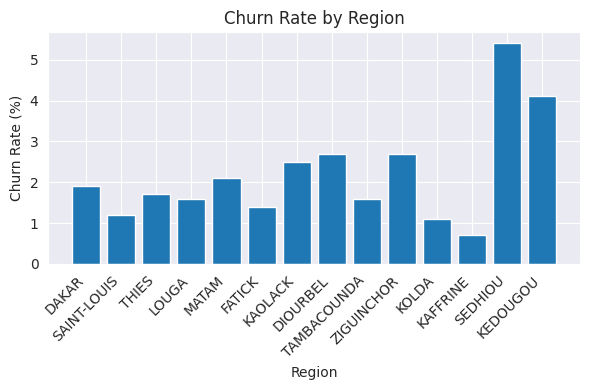

In [226]:
# Plot the churn rate per region
plt.figure(figsize=(6, 4))
plt.bar(churn_rate_by_region_df.index, churn_rate_by_region_df['CHURN RATE (%)'], tick_label=churn_rate_by_region_df['REGION'])
plt.title('Churn Rate by Region')
plt.xlabel('Region')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot into the drive through the image_path
file_name = 'Churn Rate by Region.png'
file_path = os.path.join(image_path, file_name)
plt.savefig(file_path)

# Show the chart
plt.show()

As shown above, Sedhiou region has the highest churn rate followed by Kedougou region, while Kaffrine region has the lowest churn rate.

Question 3: What is the churn rate of customers based on customer regularity?

Regularity refers to the number of times a customer is active for 90 days. The most active and least active customers will be determined first, and checked for churn.

In [227]:
# Find the highest and lowest values in the "REGULARITY" column
highest_regularity = train['REGULARITY'].max()
lowest_regularity = train['REGULARITY'].min()

# Find the user ID of the most active customer and least active customer
most_active = train[train['REGULARITY'] == highest_regularity]['user_id'].values[0]
least_active = train[train['REGULARITY'] == lowest_regularity]['user_id'].values[0]

# Check if the most active customer and least active customer churned
churned_most_active = train[train['user_id'] == most_active]['CHURN'].values[0]
churned_least_active = train[train['user_id'] == least_active]['CHURN'].values[0]

# Print the results
print(f"Customer {most_active} had the highest regularity of {highest_regularity} and {'churned' if churned_most_active == 1 else 'did not churn'}.")
print(f"Customer {least_active} had the lowest regularity of {lowest_regularity} and {'churned' if churned_least_active == 1 else 'did not churn'}.")

Customer 7ee9e11e342e27c70455960acc80d3f91c1286d1 had the highest regularity of 62 and did not churn.
Customer da90b5c1a9b204c186079f89969aa01cb03c91b2 had the lowest regularity of 1 and did not churn.


As shown above. the most active and least active customers did not churn.

Next, the usage activity of the customers will be used to group them into Low-Usage Customers, Medium-Usage Customers, and High-Usage Customers. These groups of customers will then be checked for churn.

In [228]:
# Define the usage groups and corresponding labels
bins = [0, 20, 40, float('inf')]
labels = ['Low-Usage Customers', 'Medium-Usage Customers', 'High-Usage Customers']

# Create a new column 'usage_group' to store the usage group labels
train['usage_group'] = pd.cut(train['REGULARITY'], bins=bins, labels=labels)

# Calculate the churn rate, the number of customers and the percentage of customers in each group
churn_rate_by_group = train.groupby('usage_group')['CHURN'].mean()
customers_per_group = train['usage_group'].value_counts()
percentage_customers_per_group = round((customers_per_group / customers_per_group.sum()) * 100,1)

# Remove the 'usage_group' column
train.drop('usage_group', axis=1, inplace=True)

# Create a DataFrame to display the results
usage_group_data = pd.DataFrame({'Number of Customers': customers_per_group, 'Percentage of Customers in Group(%)': percentage_customers_per_group, 'Churn Rate (%)': churn_rate_by_group})

# Display the DataFrame
usage_group_data


,Number of Customers,Percentage of Customers in Group(%),Churn Rate (%)
Low-Usage Customers,499031,46.3,0.379327
Medium-Usage Customers,202174,18.8,0.046064
High-Usage Customers,375819,34.9,0.009004


As shown in the DataFrame above, there are more Low-Usage Customers (499,031), and this group of customers have the highest churn rate (0.379327). While High-Usage Customers (375,819) have the lowest churn rate (0.009004). This suggests that customer retention policies should be targeted at the Low-Usage Customers.

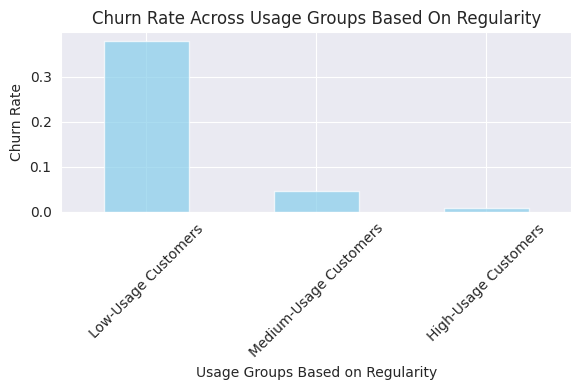

In [229]:
# Plot the churn rate across the usage groups
plt.figure(figsize=(6, 4))
churn_rate_by_group.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Churn Rate Across Usage Groups Based On Regularity')
plt.xlabel('Usage Groups Based on Regularity')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot into the drive through the image_path
file_name = 'Churn Rate Across Usage Groups Based On Regularity.png'
file_path = os.path.join(image_path, file_name)
plt.savefig(file_path)

# Show the chart
plt.show()

The chart above illustrates that Low-Usage Customers have the highest churn rate while High-Usage Customers have the lowest churn rate.

Question 4: What is the churn rate of customers based on their tenure?
A customer's tenure refers to the customer's duration in the network. The unique tenures are identified below.

In [230]:
# Identify the unique tenures in the 'TENURE' group

train['TENURE'].unique()

array(['K > 24 month', 'E 6-9 month', 'H 15-18 month', 'G 12-15 month',
       'I 18-21 month', 'J 21-24 month', 'F 9-12 month', 'D 3-6 month'],
      dtype=object)

The tenures are grouped into categories. The churn rate across these tenure groups will be examined.

In [231]:
# Calculate the number of customers, the percentage of customers, and the churn rate for each tenure
customers_per_tenure = train['TENURE'].value_counts()
percentage_customers_per_tenure = ((customers_per_tenure / customers_per_tenure.sum()) * 100).round(2)
churn_rate_by_tenure = (train.groupby('TENURE')['CHURN'].mean()).round(2) # 2 decimal places where used in both to properly display the results

# Create a DataFrame to display the results
tenure_group_data = pd.DataFrame({
    'Number of Customers': customers_per_tenure,
    'Percentage of Customers (%)': percentage_customers_per_tenure,
    'Churn Rate (%)': churn_rate_by_tenure
})

# Display the DataFrame
tenure_group_data

,Number of Customers,Percentage of Customers (%),Churn Rate (%)
D 3-6 month,387,0.04,0.14
E 6-9 month,929,0.09,0.17
F 9-12 month,4604,0.43,0.25
G 12-15 month,7520,0.70,0.32
H 15-18 month,12913,1.20,0.27
I 18-21 month,22494,2.09,0.28
J 21-24 month,6324,0.59,0.22
K > 24 month,1021853,94.88,0.18


As shown above, 94.88% of the customers have been with the network for 24 months and above (that is, 2 years and above). The churn rate among this group of customers is 0.18%, which is relatively low. The highest churn rate is 0.32% and it is observed for customers within 12-15 months duration. After one year with the network, these customers churned (became inactive for 90 days). Promotional activities such as one-year bonanza may help to retain these set of customers on the network.

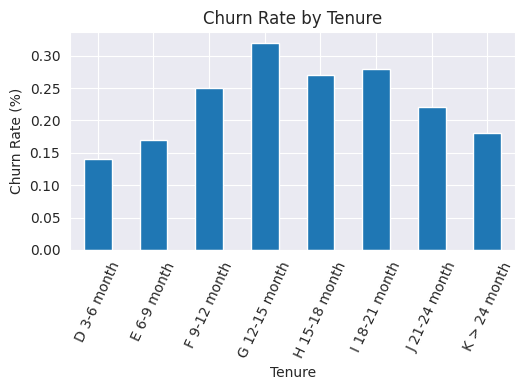

In [232]:
# Plot a bar chart for the churn rate by tenure
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
tenure_group_data['Churn Rate (%)'].plot(kind='bar')
plt.title("Churn Rate by Tenure")
plt.xlabel("Tenure")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=65)
plt.tight_layout()

# Save the plot into the drive through the image_path
file_name = 'Churn Rate by Tenure.png'
file_path = os.path.join(image_path, file_name)
plt.savefig(file_path)

# Display the chart
plt.show()

# Feature Engineering


Feature engineering is the process that transforms the dataset into the desired features in preparation for modelling.

In order to preserve the original cleaned datasets for future analysis, a copy of the train and test datasets will be created and used for feature engineering.

## Feature Selection

This is a feature engineering process that is used to choose the desired columns (columns that are relevant to the modelling) for further processing. This means that some of the columns of the train dataset will be dropped at this point, leaving only the relevant columns.

In [235]:
# List the columns in the train dataset

train.columns

Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
       'CHURN'],
      dtype='object')

In [236]:
# Identify the columns to drop
columns_to_drop = ['REGION', 'MRG', 'TOP_PACK', 'ZONE1', 'ZONE2']

# Drop these columns in the train dataset using the "drop()" method
train.drop(columns=columns_to_drop, inplace=True)
train.head()

,user_id,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK,CHURN
0,7ee9e11e342e27c70455960acc80d3f91c1286d1,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,185.0,62,30.0,0
1,50443f42bdc92b10388fc56e520e4421a5fa655c,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,0
2,da90b5c1a9b204c186079f89969aa01cb03c91b2,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0
3,364ec1b424cdc64c25441a444a16930289a0051e,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,20.0,61,7.0,0
4,d5a5247005bc6d41d3d99f4ef312ebb5f640f2cb,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,34.0,56,11.0,0


In [237]:
# Drop these columns in the test datast using the "drop()" method

test.drop(columns=columns_to_drop, inplace=True)
test.head()

,user_id,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,I 18-21 month,2500.0,5.0,2500.0,833.0,5.0,0.0,64.0,70.0,NaN,35,5.0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
2,5a4db591c953a8d8f373877fad37aaf4268899a1,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,22,NaN
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,K > 24 month,5100.0,7.0,5637.0,1879.0,15.0,7783.0,30.0,24.0,0.0,60,4.0


# Handle Missing Values

In [238]:
# First check the shape of the train dataset

train.shape

(1077024, 14)

Since the train dataset is very large (with 1,077,024 rows), the entire rows will not be used for the modelling process. A large amount of the rows of the train dataset will be dropped to optimize the modelling of the dataset. Too many rows can lead to underfitting of the models on the dataset.

The columns with missing values will be examined, to ascertain if the rows with missing values can be dropped as a means to obtain the desired sample size of the train dataset for modelling.

In [239]:
# Check the shape of the test dataset

test.shape

(190063, 13)

The test dataset has 190,063 rows.

In [240]:
# identify the columns with missing values on the train dataset

train.isnull().sum()

user_id                0
TENURE                 0
MONTANT           377885
FREQUENCE_RECH    377885
REVENUE           362355
ARPU_SEGMENT      362355
FREQUENCE         362355
DATA_VOLUME       529763
ON_NET            393174
ORANGE            447144
TIGO              644774
REGULARITY             0
FREQ_TOP_PACK     450895
CHURN                  0
dtype: int64

In [241]:
# identify the columns with missing values on the test dataset

test.isnull().sum()

user_id                0
TENURE                 0
MONTANT            66368
FREQUENCE_RECH     66368
REVENUE            63641
ARPU_SEGMENT       63641
FREQUENCE          63641
DATA_VOLUME        93347
ON_NET             69292
ORANGE             78646
TIGO              113508
REGULARITY             0
FREQ_TOP_PACK      79290
dtype: int64

In [242]:
# Calculate the percentage of missing values for each column on the train dataset
train_missing_percentage = (train.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
train_missing_percentage_df = pd.DataFrame({'Missing Percentage (%)': train_missing_percentage})

# Display the DataFrame
train_missing_percentage_df

,Missing Percentage (%)
user_id,0.00
TENURE,0.00
MONTANT,35.09
FREQUENCE_RECH,35.09
REVENUE,33.64
ARPU_SEGMENT,33.64
FREQUENCE,33.64
DATA_VOLUME,49.19
ON_NET,36.51
ORANGE,41.52


In [243]:
# Calculate the percentage of missing values for each column on the test dataset
test_missing_percentage = (test.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
test_missing_percentage_df = pd.DataFrame({'Missing Percentage (%)': test_missing_percentage})

# Display the DataFrame
test_missing_percentage_df

,Missing Percentage (%)
user_id,0.00
TENURE,0.00
MONTANT,34.92
FREQUENCE_RECH,34.92
REVENUE,33.48
ARPU_SEGMENT,33.48
FREQUENCE,33.48
DATA_VOLUME,49.11
ON_NET,36.46
ORANGE,41.38


Since 'TIGO', 'DATA_VOLUME', 'FREQ_TOP_PACK', and 'ORANGE' columns have very high percentage of missing values in both the train and test datasets, the rows with missing values across these columns will be dropped on both datasets.

In [244]:
# Create a variable for the columns with high missing values

rows_with_high_missing_values = ['TIGO', 'DATA_VOLUME', 'FREQ_TOP_PACK', 'ORANGE']

In [245]:
# Drop the rows with missing values across these columns in train dataset
train = train.dropna(subset=rows_with_high_missing_values)

# Verify that there are very little missing values
train.isnull().sum()

user_id               0
TENURE                0
MONTANT             472
FREQUENCE_RECH      472
REVENUE               1
ARPU_SEGMENT          1
FREQUENCE             1
DATA_VOLUME           0
ON_NET            11233
ORANGE                0
TIGO                  0
REGULARITY            0
FREQ_TOP_PACK         0
CHURN                 0
dtype: int64

In [246]:
# Drop the rows with missing values across these columns in test dataset
test = test.dropna(subset=rows_with_high_missing_values)

# Verify that there are very little missing values
test.isnull().sum()

user_id              0
TENURE               0
MONTANT             96
FREQUENCE_RECH      96
REVENUE              0
ARPU_SEGMENT         0
FREQUENCE            0
DATA_VOLUME          0
ON_NET            1998
ORANGE               0
TIGO                 0
REGULARITY           0
FREQ_TOP_PACK        0
dtype: int64

As can be seen above, there are now fewer rows with missing values across the columns in both the train and test datasets.

In [247]:
# Check the shape of the train and test datasets

train.shape, test.shape

((273390, 14), (48355, 13))

In [248]:
# Recheck the percentage of missing values for each column on the train dataset

train_missing_percentage = (train.isnull().mean() * 100).round(2)
train_missing_percentage_df = pd.DataFrame({'Missing Percentage (%)': train_missing_percentage})
train_missing_percentage_df

,Missing Percentage (%)
user_id,0.00
TENURE,0.00
MONTANT,0.17
FREQUENCE_RECH,0.17
REVENUE,0.00
ARPU_SEGMENT,0.00
FREQUENCE,0.00
DATA_VOLUME,0.00
ON_NET,4.11
ORANGE,0.00


In [249]:
# Recheck the percentage of missing values for each column on the test dataset

test_missing_percentage = (test.isnull().mean() * 100).round(2)
test_missing_percentage_df = pd.DataFrame({'Missing Percentage (%)': test_missing_percentage})
test_missing_percentage_df

,Missing Percentage (%)
user_id,0.00
TENURE,0.00
MONTANT,0.20
FREQUENCE_RECH,0.20
REVENUE,0.00
ARPU_SEGMENT,0.00
FREQUENCE,0.00
DATA_VOLUME,0.00
ON_NET,4.13
ORANGE,0.00


The percentage of rows with missing values is now very low for both datasets, and the total rows in the train dataset has been reduced to 273,390 to optimize the modelling process. The remaining missing values in both datasets will be handled by imputation.

## Imputation

Since the columns with missing values are numeric columns, a SimpleImputer with strategy set as 'mean' will be used to fill the missing values.

In [258]:
# Initialize the imputer

imputer = SimpleImputer(strategy='mean')

In [251]:
# Specify the columns with missing values in the train dataset
columns_with_missing_values = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'ON_NET']

# Fit the imputer to the train dataset for the specified columns
imputer.fit(train[columns_with_missing_values])

# Transform the train dataset to replace missing values with imputed values
train[columns_with_missing_values] = imputer.transform(train[columns_with_missing_values])

# Confirm that there are no more missing values in the train dataset
train.isnull().sum()

user_id           0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
REGULARITY        0
FREQ_TOP_PACK     0
CHURN             0
dtype: int64

In [252]:
# Specify the columns with missing values in the train dataset
columns_with_missing_values = ['MONTANT', 'FREQUENCE_RECH', 'ON_NET']

# Fit the imputer to the test dataset for the specified columns
imputer.fit(test[columns_with_missing_values])

# Transform the test dataset to replace missing values with imputed values
test[columns_with_missing_values] = imputer.transform(test[columns_with_missing_values])

# Confirm that there are no more missing values in the test dataset
test.isnull().sum()

user_id           0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
REGULARITY        0
FREQ_TOP_PACK     0
dtype: int64

## Obtain the features (X) and target (y) variables

In [254]:
# Specify columns to drop in the features (X) variable
dropcols = ['user_id', 'CHURN']

# Obtain the features (X) and target (y) variables on the train dataset
y = train['CHURN']
X = train.drop(columns=dropcols, axis=1)

# Obtain the features of the test dataset
test_data = test.drop(columns=['user_id'], axis=1)

# Print the shape of the features
print(X.shape)
print(y.shape)
print(test_data.shape)

(273390, 12)
(273390,)
(48355, 12)


## Data Splitting

In [257]:
# Split the features(X) and target(y) variables to obtain the training and validation sets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# Print the shape of the training and validation sets
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(218712, 12)
(218712,)
(54678, 12)
(54678,)


## Feature Scaling

In [261]:
# Specify the numeric columns

num_cols = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
            'REGULARITY', 'FREQ_TOP_PACK']

In [262]:
# Initialize the scaler

scaler = StandardScaler()

In [263]:
# Fit and transform the numerical columns of training set
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Verify that the numerical columns of training set have been standardized by the scaler
X_train.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK
463996,H 15-18 month,-0.898908,-0.984869,-0.939255,-0.939134,-0.950698,-0.456120,-0.377824,-0.518545,-0.321836,-0.026234,-0.802423
233584,K > 24 month,1.189464,2.214125,1.110936,1.110814,1.893295,-0.082235,0.010675,-0.230431,0.641127,0.865775,0.990619
1045636,K > 24 month,1.579872,0.777842,1.530445,1.530446,0.683086,-0.111363,-0.096723,1.606299,0.378501,0.929490,0.918898
671977,K > 24 month,-0.465122,-0.527870,-0.478598,-0.478599,0.138491,-0.472704,-0.352609,-0.230431,-0.321836,0.101196,-0.515536
401853,K > 24 month,-0.155274,-0.919583,-0.292582,-0.292705,-1.071719,-0.430075,0.334735,0.233754,-0.102980,0.101196,-0.730701


In [264]:
# Fit and transform the numerical columns of validation set
X_val[num_cols] = scaler.transform(X_val[num_cols])

# Verify that the numerical columns of validation set have been standardized by the scaler
X_val.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK
545753,K > 24 month,2.676733,2.148839,2.632053,2.631932,1.651254,-0.472598,1.278898,2.358597,3.311160,0.929490,2.711940
509776,K > 24 month,1.431145,2.344696,1.457281,1.457403,2.074827,0.846259,0.292710,-0.382491,-0.263474,0.865775,2.855384
919237,K > 24 month,-0.657227,-0.723727,-0.614336,-0.614459,-0.708656,0.196823,0.000532,-0.422507,-0.321836,-0.217379,-0.730701
701719,K > 24 month,-0.427940,-0.527870,-0.386929,-0.386930,-0.527124,-0.434008,-0.258286,-0.022348,-0.351016,-0.089949,-0.372093
535236,K > 24 month,0.328088,0.124986,0.322073,0.321951,0.562065,2.422594,-0.389031,0.045679,-0.336426,0.929490,-0.228649


In [265]:
# Fit and transform the numerical columns of test data
test_data[num_cols] = scaler.transform(test_data[num_cols])

# Verify that the numerical columns of test data have been standardized by the scaler
test_data.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK
4,K > 24 month,-0.390758,-0.658441,-0.339817,-0.339817,-0.345593,0.354691,-0.367551,-0.438513,-0.365607,0.802060,-0.587258
10,K > 24 month,-0.713000,-0.593155,-0.660718,-0.660841,-0.769166,-0.472704,-0.057499,-0.406501,-0.321836,0.802060,-0.515536
11,K > 24 month,-0.812151,-0.919583,-0.825065,-0.825187,-1.011208,-0.472385,-0.389965,-0.390494,-0.190523,-1.173103,-0.802423
19,K > 24 month,-0.601455,-0.527870,-0.612145,-0.612267,-0.708656,-0.102008,-0.389965,-0.534551,-0.321836,0.610915,-0.802423
25,K > 24 month,-0.527091,-0.593155,-0.539102,-0.539224,-0.769166,-0.472704,-0.245211,0.065687,-0.248884,0.738345,-0.300371


## Feature Encoding

The only categorical column on the datasets is the 'TENURE' column.

In [266]:
# Initialize the encoder

encoder = LabelEncoder()

In [268]:
# Fit and transform the 'TENURE' column of training set
X_train['TENURE'] = encoder.fit_transform(X_train['TENURE'])

# Verify that the 'TENURE' column of training set has been encoded by the encoder
X_train.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK
463996,4,-0.898908,-0.984869,-0.939255,-0.939134,-0.950698,-0.456120,-0.377824,-0.518545,-0.321836,-0.026234,-0.802423
233584,7,1.189464,2.214125,1.110936,1.110814,1.893295,-0.082235,0.010675,-0.230431,0.641127,0.865775,0.990619
1045636,7,1.579872,0.777842,1.530445,1.530446,0.683086,-0.111363,-0.096723,1.606299,0.378501,0.929490,0.918898
671977,7,-0.465122,-0.527870,-0.478598,-0.478599,0.138491,-0.472704,-0.352609,-0.230431,-0.321836,0.101196,-0.515536
401853,7,-0.155274,-0.919583,-0.292582,-0.292705,-1.071719,-0.430075,0.334735,0.233754,-0.102980,0.101196,-0.730701


In [270]:
# Fit and transform the 'TENURE' column of validation set
X_val['TENURE'] = encoder.fit_transform(X_val['TENURE'])

# Verify that the 'TENURE' column of validation set has been encoded by the encoder
X_val.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK
545753,7,2.676733,2.148839,2.632053,2.631932,1.651254,-0.472598,1.278898,2.358597,3.311160,0.929490,2.711940
509776,7,1.431145,2.344696,1.457281,1.457403,2.074827,0.846259,0.292710,-0.382491,-0.263474,0.865775,2.855384
919237,7,-0.657227,-0.723727,-0.614336,-0.614459,-0.708656,0.196823,0.000532,-0.422507,-0.321836,-0.217379,-0.730701
701719,7,-0.427940,-0.527870,-0.386929,-0.386930,-0.527124,-0.434008,-0.258286,-0.022348,-0.351016,-0.089949,-0.372093
535236,7,0.328088,0.124986,0.322073,0.321951,0.562065,2.422594,-0.389031,0.045679,-0.336426,0.929490,-0.228649


In [271]:
# Fit and transform the 'TENURE' column of test data
test_data['TENURE'] = encoder.fit_transform(test_data['TENURE'])

# Verify that the 'TENURE' column of test data has been encoded by the encoder
test_data.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,REGULARITY,FREQ_TOP_PACK
4,7,-0.390758,-0.658441,-0.339817,-0.339817,-0.345593,0.354691,-0.367551,-0.438513,-0.365607,0.802060,-0.587258
10,7,-0.713000,-0.593155,-0.660718,-0.660841,-0.769166,-0.472704,-0.057499,-0.406501,-0.321836,0.802060,-0.515536
11,7,-0.812151,-0.919583,-0.825065,-0.825187,-1.011208,-0.472385,-0.389965,-0.390494,-0.190523,-1.173103,-0.802423
19,7,-0.601455,-0.527870,-0.612145,-0.612267,-0.708656,-0.102008,-0.389965,-0.534551,-0.321836,0.610915,-0.802423
25,7,-0.527091,-0.593155,-0.539102,-0.539224,-0.769166,-0.472704,-0.245211,0.065687,-0.248884,0.738345,-0.300371


# Modelling

In [ ]:
# Create a list of models to train and evaluate
models = [
    ('Logistic Regression', LogisticRegression(random_state=42, C=1.0, penalty='l2', solver='lbfgs')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=2, min_samples_leaf=1)),
    ('Random Forest', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0)),
    ('Adaptive Boosting', AdaBoostClassifier(random_state=42, n_estimators=50, learning_rate=1.0, base_estimator=DecisionTreeClassifier(max_depth=1))),
    ('Support Vector Machine', SVC(random_state=42, C=1.0, kernel='rbf', gamma='scale')),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski'))
]

In [ ]:
rand = RandomForestClassifier(bootstrap=True,criterion = "gini", n_jobs=-1, max_depth=7, n_estimators=200, random_state=1, verbose=True)

In [ ]:
#Fit model on data
randmodel = rand.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished


In [ ]:
#Predict on the X_test data
randpred = randmodel.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    5.4s finished


In [ ]:
print("Acuracy")
accuracy_score(y_test, randpred)

Acuracy


0.8645601212229254

In [ ]:
print("Recall")
recall_score(y_test, randpred)

Recall


0.5855144751129202

In [ ]:
print("F1 Score")
f1_score(y_test, randpred)

F1 Score


0.618194096184349

In [ ]:
confusion_matrix(y_test, randpred)

array([[813059,  62274],
       [ 83598, 118093]])

In [ ]:
# Making a submission

In [ ]:
submission.head()

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0
1,000055d41c8a62052dd426592e8a4a3342bf565d,0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0


In [ ]:
test.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,7,-0.092733,-0.611459,-0.086950,-0.086782,-0.750871,-0.002009,0.144956,-0.540553,-0.456498,0.00054,0.011407,0.625630,-0.457526
1,5,-0.914993,-0.892827,-0.887609,-0.887442,-0.918340,-0.315856,0.002055,-0.610935,0.000454,0.00054,0.011407,0.580766,-0.886992
2,7,-0.390146,1.264326,-0.361031,-0.361206,1.007548,0.402807,-0.399600,-0.598139,-0.456498,0.00054,0.011407,1.298587,1.367700
3,7,-0.000892,0.000033,-0.001355,-0.001355,-0.000783,-0.002009,0.002055,-0.001856,0.000454,0.00054,0.011407,-0.854876,0.000024
4,7,-0.000892,0.000033,-0.001355,-0.001355,-0.000783,-0.002009,0.002055,-0.001856,0.000454,0.00054,0.011407,-0.810012,0.000024


In [ ]:
subpred = randmodel.predict(test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.1s finished


In [ ]:
subpred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
submission["CHURN"] = subpred

In [ ]:
submission.head()

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0
1,000055d41c8a62052dd426592e8a4a3342bf565d,0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0


In [ ]:
submission.to_csv('starter_code_submission.csv', index=False)

In [ ]:
# 1. Do more feature engineering
# 2. Handle the imbalance nature of the predictor class
# 3. Use other algorithms
# 4. Tune hyperparameters of this model
# 5. Handle missing values properly
# 6. Any other thing you feel can improve the performance of the model is good to go


### Good Luck !!!